<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/LQR_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install control numpy scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 10.9 MB/s eta 0:00:00


Rank of controllability matrix: 2


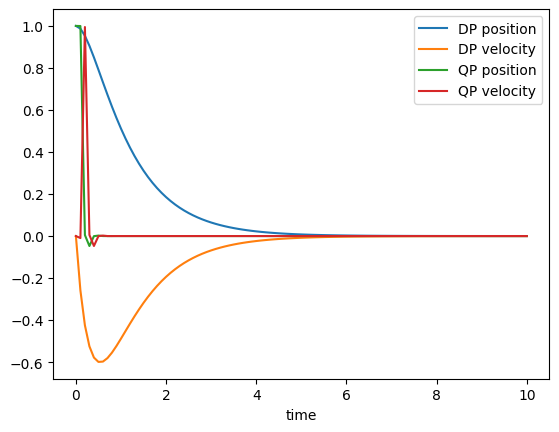

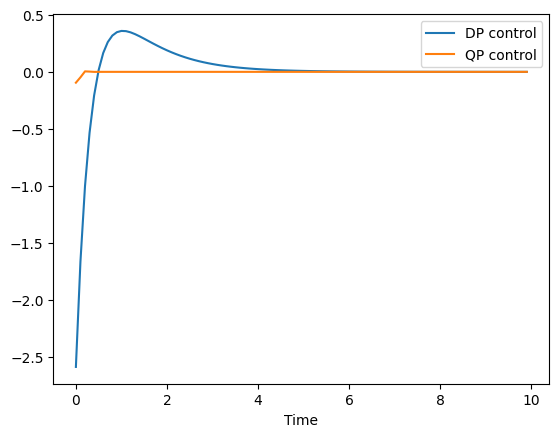

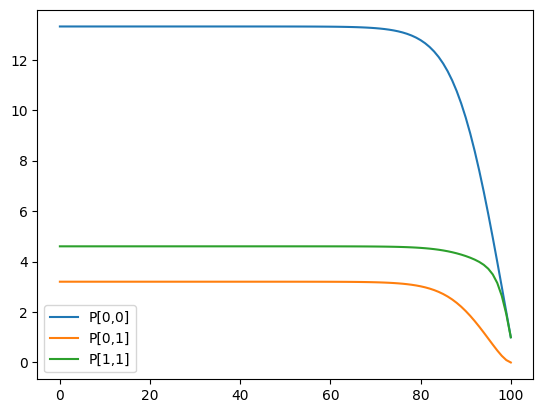

Cost DP: 6.658612208961309
Cost QP: 1.4971524239201222
Difference K[:,:,0] - Kinf: [[-6.72931533e-09 -2.28763808e-09]]
Difference P[:,:,0] - Pinf: [[-2.32084005e-08 -7.88973509e-09]
 [-7.88973509e-09 -2.68212297e-09]]
xsub - xhist[:,k:end]: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]]
usub - uhist[:,k:end]: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
Finite difference gradient estimate: [ 0.07638569 -0.01298491]
DP gradient estimate: [ 0.07637903 -0.01298721]
QP multiplier at time k: [ 1.48314032e-17 -3.37099144e-50]


In [9]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from control import dlqr, dare
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.sparse import kron, eye, diags

# Discrete dynamics
h = 0.1
A = np.array([[1, h],
              [0, 1]])
B = np.array([[0.5*h*h],
              [h]])

# Controllability rank check
ctrb_matrix = np.hstack([B, A @ B])
rank = np.linalg.matrix_rank(ctrb_matrix)
print(f"Rank of controllability matrix: {rank}")

n = 2  # states
m = 1  # controls
Tfinal = 10.0
N = int(Tfinal/h) + 1
thist = np.linspace(0, h*(N-1), N)

# Initial condition
x0 = np.array([1.0, 0.0])

# Cost weights
Q = np.eye(n)
R = 0.1 * np.eye(m)
Qn = np.eye(n)

# Cost function
def J(xhist, uhist):
    cost = 0.5 * xhist[:, -1].T @ Qn @ xhist[:, -1]
    for k in range(N-1):
        cost += 0.5 * xhist[:, k].T @ Q @ xhist[:, k] + 0.5 * uhist[:, k].T @ R @ uhist[:, k]
    return cost

# Cost-to-go functions
def Vinf(x):
    return 0.5 * x.T @ Pinf @ x

def V(k, x):
    return 0.5 * x.T @ P[:, :, k] @ x

# QP solution for xhist, uhist

# Build block diagonal matrix H (cost)
# R for controls: m x m blocks, Q for states: n x n blocks
blocks = []
blocks.append(sp.csr_matrix(R))  # first control block
for _ in range(N-2):
    blocks.append(sp.block_diag((Q, R)))
blocks.append(sp.csr_matrix(Qn))  # final state cost

# To create H as block diagonal of all control and state costs:
# We want a block diagonal matrix with pattern: [R, Q, R, Q, R, ..., Qn]

# But the Julia code uses blockdiag(R, kron(I(N-2), blockdiag(Q,R)), Qn)
# So construct accordingly:

# First control block (R)
H_blocks = [R]

# Then N-2 blocks of [Q R] along diagonal
for _ in range(N-2):
    H_blocks.append(block_diag(Q, R))

# Final Qn block
H_blocks.append(Qn)

# Combine blocks into a block diagonal matrix
H = sp.block_diag(H_blocks, format='csr')

# Constraints matrix C

# Construct kron(I_{N-1}, [B -I_n])
I_N_1 = sp.eye(N-1)
C_block = sp.hstack([sp.csr_matrix(B), -sp.eye(n)])
C = sp.kron(I_N_1, C_block)

# Insert A matrices in constraints according to the pattern

# Convert C to lil for easier slicing assignment
C = C.tolil()

for k in range(N-2):
    row_start = (k+1)*n
    col_start = (k*(n+m))
    C[row_start:row_start+n, col_start:col_start+n] = A

C = C.tocsr()

# Right hand side vector d
d = np.zeros(C.shape[0])
d[:n] = -A @ x0

# Solve KKT system: [H C'; C 0] [z; lambda] = [0; d]
KKT_top = sp.hstack([H, C.transpose()])
KKT_bottom = sp.hstack([C, sp.csr_matrix((C.shape[0], C.shape[0]))])
KKT = sp.vstack([KKT_top, KKT_bottom]).tocsc()

rhs = np.concatenate([np.zeros(H.shape[0]), d])

# Solve linear system
y = spla.spsolve(KKT, rhs)

# Extract multipliers
lambda_hist_qp = y[H.shape[0]:].reshape(n, N-1)

# Extract states and controls
z = y[:H.shape[0]]
Z = z.reshape(m + n, N-1, order='F')  # column-major reshape to match Julia

xhist_qp = np.hstack([x0.reshape(-1,1), Z[m:, :]])
uhist_qp = Z[:m, :]

# Dynamic Programming for P and K
P = np.zeros((n, n, N))
K = np.zeros((m, n, N-1))

P[:, :, N-1] = Qn

for k in range(N-2, -1, -1):
    temp = R + B.T @ P[:, :, k+1] @ B
    K[:, :, k] = np.linalg.solve(temp, B.T @ P[:, :, k+1] @ A)
    P[:, :, k] = Q + K[:, :, k].T @ R @ K[:, :, k] + (A - B @ K[:, :, k]).T @ P[:, :, k+1] @ (A - B @ K[:, :, k])

# Forward rollout starting at x0
xhist = np.zeros((n, N))
xhist[:, 0] = x0
uhist = np.zeros((m, N-1))

for k in range(N-1):
    uhist[:, k] = -K[:, :, k] @ xhist[:, k]
    xhist[:, k+1] = A @ xhist[:, k] + B.flatten() * uhist[:, k]

# Plot
plt.plot(thist, xhist[0, :], label="DP position")
plt.plot(thist, xhist[1, :], label="DP velocity")
plt.plot(thist, xhist_qp[0, :], label="QP position")
plt.plot(thist, xhist_qp[1, :], label="QP velocity")
plt.xlabel("time")
plt.legend()
plt.show()

plt.plot(thist[:-1], uhist[0, :], label="DP control")
plt.plot(thist[:-1], uhist_qp[0, :], label="QP control")
plt.xlabel("Time")
plt.legend()
plt.show()

plt.plot(range(N), P[0, 0, :], label="P[0,0]")
plt.plot(range(N), P[0, 1, :], label="P[0,1]")
plt.plot(range(N), P[1, 1, :], label="P[1,1]")
plt.legend()
plt.show()

print("Cost DP:", J(xhist, uhist))
print("Cost QP:", J(xhist_qp, uhist_qp))

# Infinite horizon solution
Kinf, _, _ = dlqr(A, B, Q, R)
print("Difference K[:,:,0] - Kinf:", K[:, :, 0] - Kinf)

Pinf_matrix, _, _ = dare(A, B, Q, R)
# Access the first element of the tuple returned by dare
print("Difference P[:,:,0] - Pinf:", P[:, :, 0] - Pinf_matrix)


# Rollout function from time k_start
def rollout(k_start, x_start):
    # x_start is the state at time k_start
    # This function rolls out from time k_start to N-1
    N_sub = N - k_start
    xsub = np.zeros((n, N_sub))
    xsub[:, 0] = x_start
    usub = np.zeros((m, N_sub - 1)) # Controls from time k_start to N-2
    for j in range(N_sub - 1):
        # k is the original time index: k_start + j
        k_orig = k_start + j
        usub[:, j] = -K[:, :, k_orig] @ xsub[:, j]
        xsub[:, j+1] = A @ xsub[:, j] + B.flatten() * usub[:, j]
    return xsub, usub

# Cost function for a sub-trajectory starting at time k_start
def J_sub(k_start, x_sub, u_sub):
    # x_sub is (n, N_sub), u_sub is (m, N_sub - 1) where N_sub = N - k_start

    # Cost at the final state of the sub-trajectory (which corresponds to the final state of the full trajectory)
    cost = 0.5 * x_sub[:, -1].T @ Qn @ x_sub[:, -1]

    # Add costs for the intermediate states and controls in the sub-trajectory
    N_sub = x_sub.shape[1]
    for j in range(N_sub - 1): # Loop through the control steps in the sub-trajectory
        # x_sub[:, j] is the state at original time k_start + j
        # u_sub[:, j] is the control at original time k_start + j
        cost += 0.5 * x_sub[:, j].T @ Q @ x_sub[:, j] + 0.5 * u_sub[:, j].T @ R @ u_sub[:, j]
    return cost

# Generate a sub-trajectory starting at xhist[:, k]
k = 50 # This is the starting time index k_start for the finite difference
# Ensure k is a valid index within the trajectory
if k < 0 or k >= N-1:
    raise ValueError(f"k must be between 0 and {N-2}")

# Generate the baseline sub-trajectory from time k
xhist_sub = xhist[:, k:]
uhist_sub = uhist[:, k:N-1]

print("xsub - xhist[:,k:end]:", rollout(k, xhist[:, k])[0] - xhist_sub)
print("usub - uhist[:,k:end]:", rollout(k, xhist[:, k])[1] - uhist_sub)


eps = 1e-6
grad_fd = np.zeros(n)

# Calculate the baseline cost for the sub-trajectory starting at time k
base_cost = J_sub(k, xhist_sub, uhist_sub)

for i in range(n):
    dx = np.zeros(n)
    dx[i] = eps
    # Perturb the state at time k
    x_plus_at_k = xhist[:, k] + dx

    # Rollout from the perturbed state at time k
    x1p_sub, u1p_sub = rollout(k, x_plus_at_k)

    # Calculate the cost of the perturbed sub-trajectory starting at time k
    cost_plus = J_sub(k, x1p_sub, u1p_sub)

    # Calculate the finite difference gradient
    grad_fd[i] = (cost_plus - base_cost) / eps

print("Finite difference gradient estimate:", grad_fd)

# To compare multipliers from QP to cost-to-go gradient from DP, you would use
# automatic differentiation libraries like JAX, autograd or PyTorch.
# The gradient of the cost-to-go V(k, x) with respect to x is P[:,:,k] @ x.
# The QP multipliers lambda_hist_qp[:, k] should be related to this gradient.
# Let's calculate the DP gradient at time k=50 and compare:
dp_gradient_at_k = P[:,:,k] @ xhist[:,k]
print("DP gradient estimate:", dp_gradient_at_k)
print("QP multiplier at time k:", lambda_hist_qp[:, k])

# Note: The QP multipliers might be related to the gradient of the terminal cost or
# the cost-to-go function depending on the exact QP formulation. In a standard
# finite-horizon LQR setting, the multiplier lambda_k is often interpreted as
# the gradient of the cost-to-go w.r.t. the state at time k.